In [1]:
import pandas as pd
from merlion.utils import TimeSeries

# 加载数据
air_pass = pd.read_csv("data/airline-passengers.csv")
# 把日期设置为索引
air_pass.set_index('Month', inplace=True)
air_pass.index = pd.to_datetime(air_pass.index)
# 一定要确保freq设定好
air_pass.index.freq = 'MS'

# 读取为TimeSeries对象
air_pass_ts = TimeSeries.from_pd(air_pass, freq='MS')
print(air_pass_ts.is_aligned)

# 使用 .bisect() 函数切分数据为训练集和测试集
# 我们希望预估未来6个月的乘客量
air_pass_ts_train, air_pass_ts_test = air_pass_ts.bisect('1960-07-01')

True


In [3]:
# 使用lgbm和autosarima两个方法
from merlion.models.forecast.trees import LGBMForecaster, LGBMForecasterConfig
from merlion.models.automl.autosarima import AutoSarima, AutoSarimaConfig

# 使用模型集成技术
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig

# 设定训练设置
from merlion.models.ensemble.base import EnsembleTrainConfig
# 定义模型
lgbm_config = LGBMForecasterConfig(maxlags = 30, max_forecast_steps=len(air_pass_ts_test))
lgbm = LGBMForecaster(lgbm_config)
sarima_config = AutoSarimaConfig(auto_pqPQ=True, auto_d=True, auto_D=True, auto_seasonality=True, approximation=True, maxiter=5)
sarima = AutoSarima(sarima_config)
# 传统集成，多模型求均值
ensemble_config = ForecasterEnsembleConfig(
    combiner=Mean(), models=[lgbm,sarima]
)
# 集成配置
# 我们使用20%的数据作为验证集
ensemble_train_config = EnsembleTrainConfig(valid_frac=0.2,
                                            per_model_train_configs=[None,{
                                                "enforce_stationarity": True,
                                                 "enforce_invertibility": True
                                            }])
# 训练与预测
ensemble = ForecasterEnsemble(config=ensemble_config)
ensemble.train(air_pass_ts_train,train_config=ensemble_train_config)
ensemble.forecast(air_pass_ts_test.time_stamps)

Inferred granularity <MonthBegin>
Inferred granularity <MonthBegin>
Inferred granularity <MonthBegin>


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 108, number of used features: 30
[LightGBM] [Info] Start training from score 307.055556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

(            Passengers
 time                  
 1960-07-01  539.854082
 1960-08-01  546.128546
 1960-09-01  496.473558
 1960-10-01  461.392224
 1960-11-01  430.954562
 1960-12-01  459.967804,
 None)

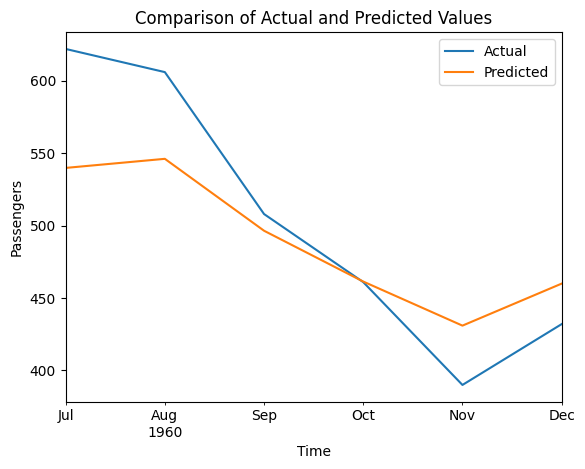

In [6]:
import matplotlib.pyplot as plt

# Get the predicted values from the ensemble forecast
predicted_values = ensemble.forecast(air_pass_ts_test.time_stamps)[0].to_pd()

# Create a dataframe to compare the predicted values with the actual values
comparison_df = pd.DataFrame({'Actual': air_pass_ts_test.to_pd()['Passengers'], 'Predicted': predicted_values['Passengers']})

# Plot the comparison dataframe
comparison_df.plot()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()
